In [1]:
import sys
import warnings

sys.path.append("/workspaces/ood/")
%load_ext autoreload
%autoreload 2
warnings.filterwarnings("ignore")

import torch
from albumentations.pytorch import ToTensorV2
import albumentations as A

from anomalib.config import get_configurable_parameters
from anomalib.models import get_model
from anomalib.data.mvtec import MVTec

from ood.draw import draw_score_distr_plot
from ood.eval import make_predictions_fastflow
from ood.ood_metrics import get_measures
from ood.utils import prettify_value

device = torch.device("cuda")
torch.cuda.is_available()
torch.cuda.set_device(1)
torch.cuda.current_device()

1

### BYOL evaluation

In [2]:
config = get_configurable_parameters(
    model_config_path="/workspaces/ood/anomalib/anomalib/models/fastflow/config.yaml",
)

In [3]:
pre_process = A.Compose(
    [
        A.Resize(height=32, width=32, always_apply=True),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

In [4]:
test_data = MVTec(
    root="/workspaces/ood/data/cifar10_full_size",
    category="ood",
    split="test",
    pre_process=pre_process,
    task="classification",
)

In [5]:
model = get_model(config).to(device)
model.load_state_dict(
    torch.load("/workspaces/ood/data/models/byol_fastflow_long_train.ckpt")[
        "state_dict"
    ]
)

pool dims [2048]
CNF coder: 2048


<All keys matched successfully>

In [6]:
in_scores, out_scores = make_predictions_fastflow(
    model=model, dataset=test_data, device=device
)
scores_distr = {
    "cifar": in_scores,
    "svhn": out_scores,
}

100%|██████████| 36032/36032 [14:39<00:00, 40.97it/s]


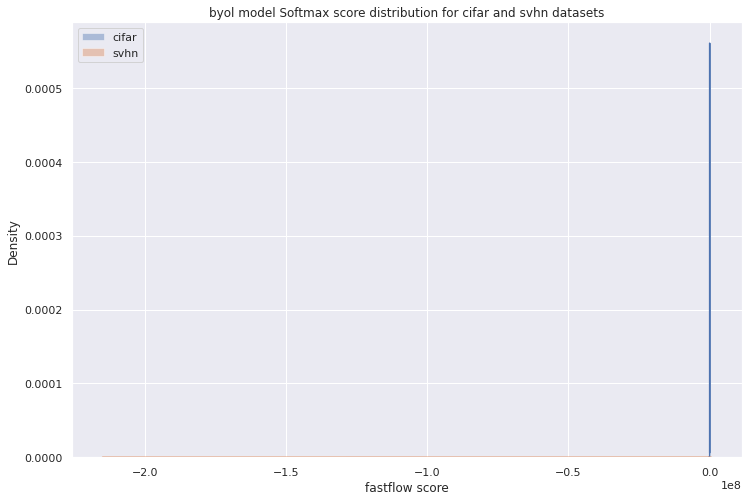

In [7]:
model_name = "byol"

draw_score_distr_plot(
    scores_distr=scores_distr,
    score_type="fastflow",
    model_name=model_name,
    in_data_name="cifar",
    out_data_name="svhn",
)

In [8]:
auroc, aupr, fpr = get_measures(scores_distr["cifar"], scores_distr["svhn"])
auroc, aupr, fpr = prettify_value((auroc, aupr, fpr), num_round=5, ljust_num=7)

print(f" {model_name} softmax scores: \n auroc {auroc}\n aupr  {aupr}\n FPR95 {fpr}")

 byol softmax scores: 
 auroc 0.86939
 aupr  0.73948
 FPR95 0.48901
